In [80]:
import os
import gzip
import glob2
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from numpy import diff
from scipy.optimize import curve_fit
import csv
import math
from scipy.special import erfc
from scipy.special import erf
directory = os.getcwd()

In [2]:
# No need to run again!!

# dirList = glob2.glob(directory+'\\mapsa-round2-data\\*')
# tarball = tarfile.open(directory+'\\mapsa-round2-data\\HPK25_1.tar.gz')
# tb = tarball.extractall()

# for i in dirList:
#     tarball = tarfile.open(i)
#     tarball.extractall()


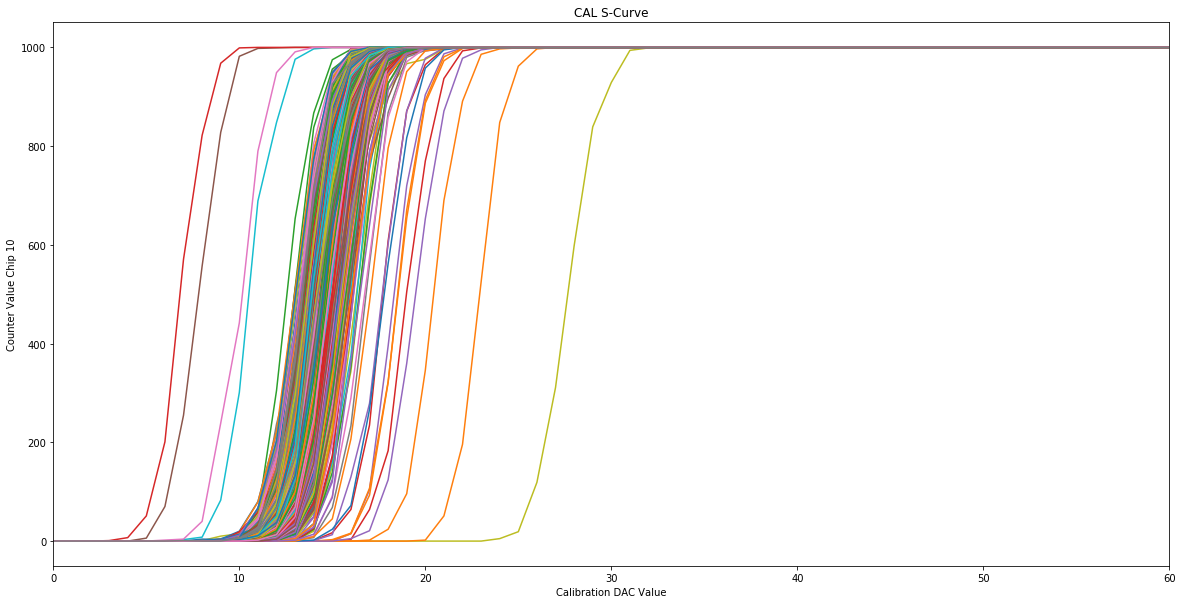

In [18]:
# Comparison s-curve
# chip 1

chip1Mean = open(directory+'\\HPK25_1\\mpa_test_HPK25_1_Chip1_2021_02_08_08_57_42_PostTrim_CAL_CAL_Mean.csv','rb')

CALscurve_file = open(directory+'\\HPK25_1\\mpa_test_HPK25_1_Chip1_2021_02_08_08_57_42_PostTrim_CAL_CAL.csv','r')


calList = []
n = 0
for j in CALscurve_file:
    r = j.strip('\n').split(',')[1:]
    r = list(map(float, r))
    calList.append(r)
    #calList = list(map(int, calList))
calList = calList[1:]

fig = plt.figure(figsize=(20,10))
x = np.arange(0,256)
m = 0
for j in calList:
    plt.plot(x, calList[m][:256])
    plt.xlim(0,60)
    m += 1
plt.ylabel('Counter Value Chip 10')
plt.xlabel('Calibration DAC Value')
plt.title('CAL S-Curve')
plt.show()
CALscurve_file.close()
chip1Mean.close()

In [47]:
len(calList)
len(calList[1])

257

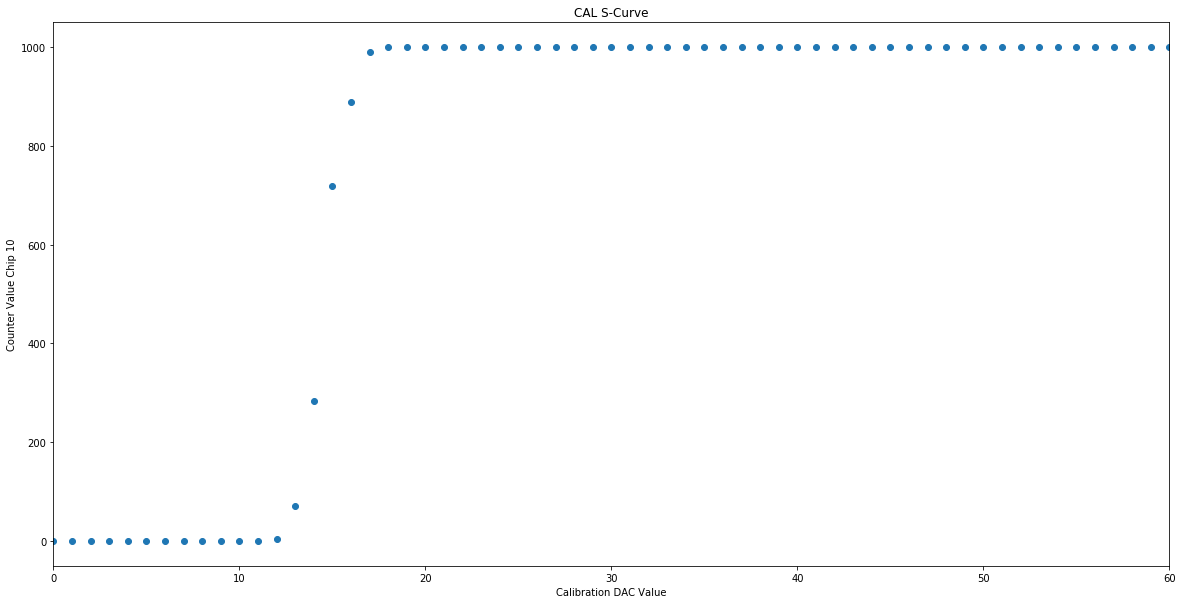

In [3]:
fig = plt.figure(figsize=(20,10))
x = np.arange(0,256)
plt.plot(x, calList[1][:256],'o')
plt.xlim(0,60)
plt.ylabel('Counter Value Chip 10')
plt.xlabel('Calibration DAC Value')
plt.title('CAL S-Curve')
plt.show()

(-50, 350)

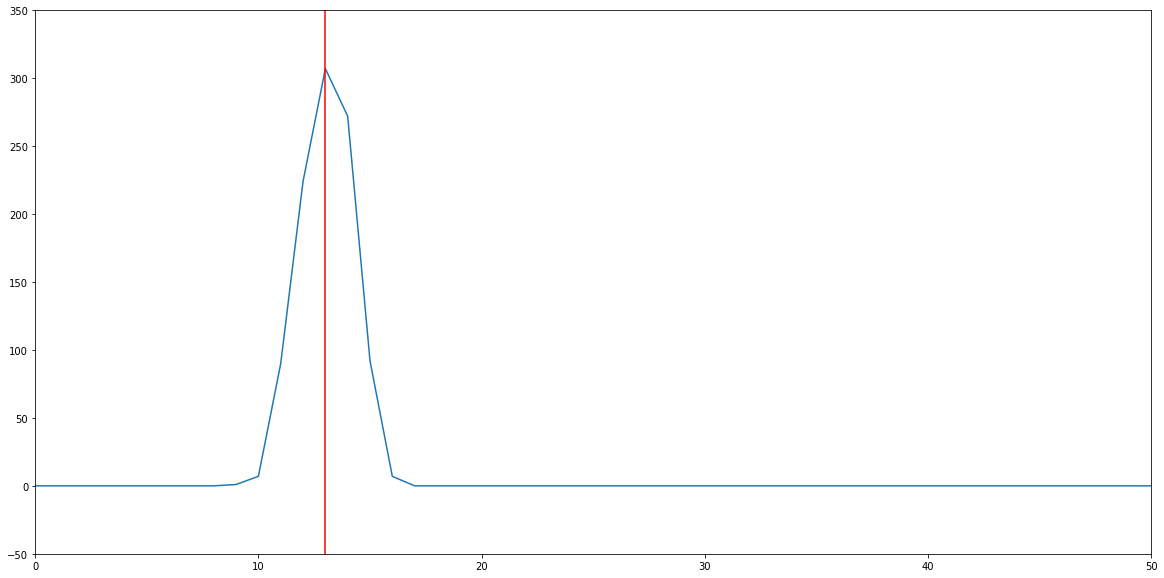

In [4]:
fig = plt.figure(figsize=(20,10))
dx = 1
y = calList[47]
dy = diff(y)/dx
plt.plot(x, dy)
plt.axvline(x=np.argmax(dy),c='r')
plt.xlim(0,50)
plt.ylim(-50,350)

In [5]:
np.argmax(dy)

13

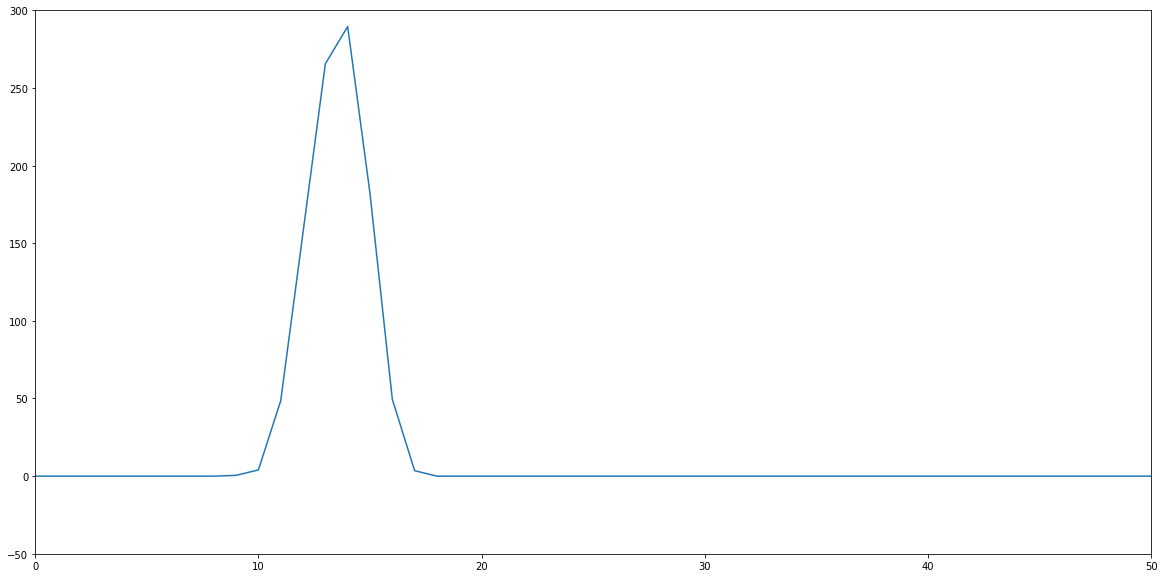

In [7]:
fig = plt.figure(figsize=(20,10))
grad = np.gradient(y)
plt.plot(np.arange(0,257),grad)
plt.xlim(0,50)
plt.ylim(-50,300)
plt.show()

In [8]:
np.argmax(grad)

14

In [9]:
np.mean(dy[:255])

3.9215686274509802

In [10]:
#rms = np.sqrt(np.mean(dy[:255]**2))
rms = np.sqrt(np.argmax(dy**2))
rms

15.968719422671311

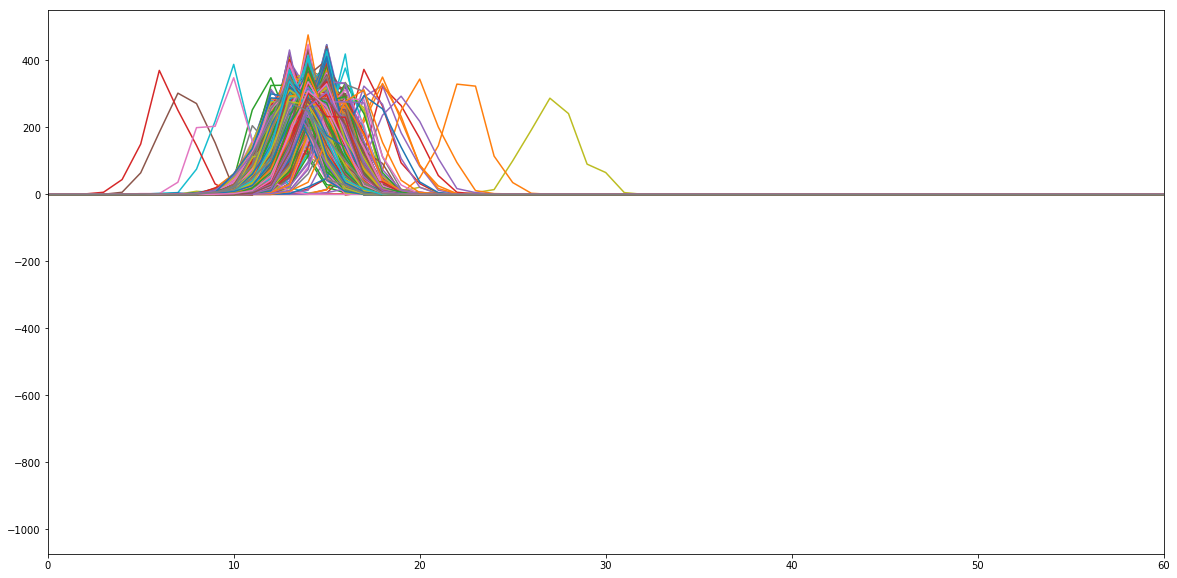

In [11]:
fig = plt.figure(figsize=(20,10))
for j in calList:
    dy = diff(j)/dx
    plt.plot(x, dy)
    plt.xlim(0,60)
    m += 1
plt.show()

C:\Users\nicol\anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


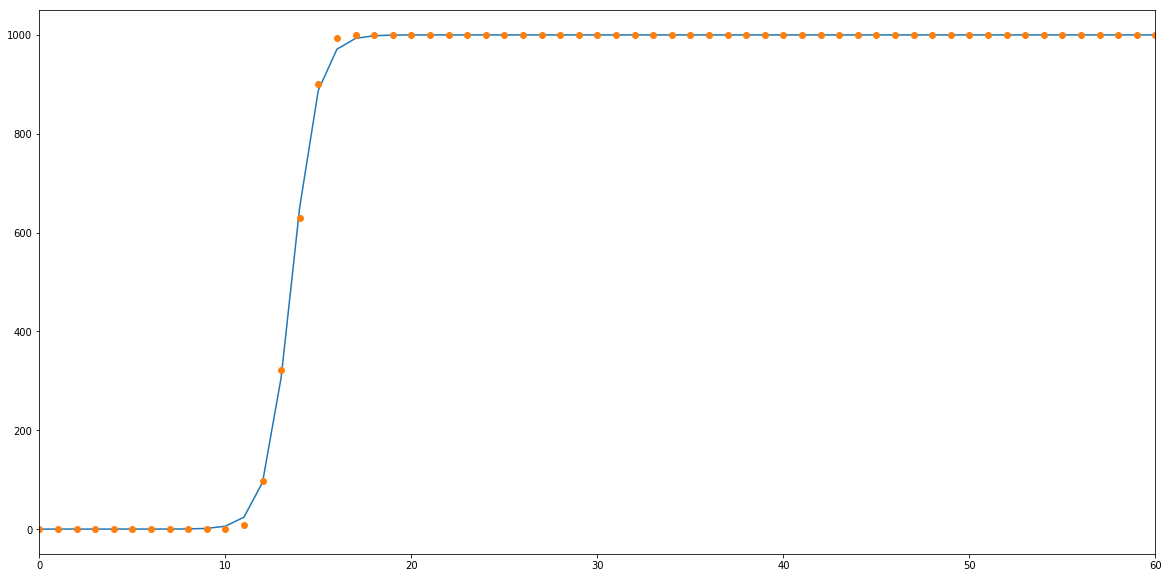

In [14]:
# Fitting sigmoid to data

y = calList[47][:256]
fig = plt.figure(figsize=(20,10))
# Sigma fit
def sig(x,x0,a,k):
    y = a / (1 + np.exp(-k*(x-x0)))
    return y

p0 = [10, 500, 1.9]
#print(len(yL))

popt, pcov = curve_fit(sig, x, y, p0, method='lm')

plt.plot(sig(x, *popt))
plt.plot(x,y,'o')
plt.xlim(0,60)
plt.show()


In [25]:
csvfilename = directory+'\\HPK25_1\\mpa_test_HPK25_1_Chip1_2021_02_08_08_57_42_PostTrim_CAL_CAL.csv'

def loadSCurvesFromCSV(csvfilename):
    #print(csvfilename)
    #scurvedict = dict()
    scurves = []
    #pixels = []
    start = 0
    stop = 256
    step = 1
    with open(csvfilename, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            scurve = []
            if row[0] == '':
                start = int(row[1])
                stop = int(row[-1])
                step = int(row[2])-int(row[1])
                continue
            pixedid = int(row[0])
            for i in range(1,len(row)):
                scurve.append(int(row[i]))
            #scurve = row[1:]
            #pixels.append(pixedid)
            scurves.append(scurve)
            #scurvedict[pixedid] = scurve
    #return scurvedict,start,stop,step
    return scurves,start,stop,step


scurves, start, stop, step = loadSCurvesFromCSV(csvfilename)


In [50]:
len(scurves[1])

257

In [32]:
step

1

In [121]:
def extract_scurve_differentiate(s_curve,s_type="CAL",n_pulse=1000,nominal_DAC=-1,start=0,stop=256):
    if nominal_DAC == -1:
        if s_type=="THR":
            nominal_DAC = 85
        elif s_type=="CAL":
            nominal_DAC = 15
    rms  = -1
    scurve = np.array(s_curve)
   # print(scurve,'h')
    ##scurve = np.delete(scurve, -1)#last entry always a 0
    scurve = scurve[0][:256]
    #print(scurve)
    step = min(int((stop-start)/len(scurve)),1)
    step = 1
    DACvals = np.array(range(start,stop,step))
    if len(DACvals) != len(scurve):
        print("len(scurve) "+str(len(scurve))+", len(DACvals) "+str(len(DACvals)))
        return -1,-1,False
    #print(DACvals)
    differentiated = np.diff(scurve)/np.diff(DACvals)
    minmaxs = []
    if s_type == "THR":
        minmaxs = (np.diff(np.sign(np.diff(differentiated))) > 0).nonzero()[0] + 1 # local min
    elif s_type == "CAL":
        minmaxs = (np.diff(np.sign(np.diff(differentiated))) < 0).nonzero()[0] + 1 # local max

    scurvesvals = []
    for i in minmaxs: scurvesvals.append(scurve[i])
    meanpos = 0
    if len(scurvesvals)>0:
        meanpos = min(range(len(scurvesvals)), key=lambda i: abs(scurvesvals[i]-(n_pulse/2.)))
    else:
        print("No s curve found.")
        return -1,-1,False
    if (minmaxs[meanpos] <= (start +1)) or (minmaxs[meanpos] >= (stop -1)):#no good position to extract 
        return -1,-1,False
    if scurve[meanpos]<0 or scurve[meanpos]>n_pulse:
        return -1,-1,False
    findmeanx = [DACvals[minmaxs[meanpos]-1],DACvals[minmaxs[meanpos]],DACvals[minmaxs[meanpos]+1]]
    findmeany = [scurve[minmaxs[meanpos]-1],scurve[minmaxs[meanpos]],scurve[minmaxs[meanpos]+1]]
    linefit = np.polyfit(findmeanx,findmeany,1)
    if linefit[0] == 0:
        print("Fit failed.")
        return -1,-1,False
    truemean = ((n_pulse/2)-linefit[1])/linefit[0]
    closestpos_truemean = min(range(len(DACvals)), key=lambda i: abs(DACvals[i]-truemean))
    sigma1 = False
    #sigma1val = 0.21
    sigma1val = 0.37
    idx1_a = closestpos_truemean
    idx1_b = closestpos_truemean
    true1sigmaplus  = -1
    true1sigmaminus = -1
    while (not sigma1) and (idx1_a>0) and idx1_a < (len(DACvals)-2):#2 sigma
        if abs(differentiated[idx1_a])<=sigma1val*abs(differentiated[closestpos_truemean]):
            sigma1 = True
            break
        idx1_a += 1
    sigma1 = False
    if (idx1_a>0) and (idx1_a<(len(DACvals)-1)) and (abs(abs(differentiated[idx1_a-1])-sigma1val*n_pulse)<abs(abs(differentiated[idx1_a])-sigma1val*n_pulse)): idx1_a -= 1
    while (not sigma1) and idx1_b > 0 and idx1_b < (len(DACvals)-2):#2 sigma
        if abs(differentiated[idx1_b])<=sigma1val*abs(differentiated[closestpos_truemean]):
            sigma1 = True
            break
        idx1_b -= 1
    if (idx1_b>0) and (idx1_b<(len(DACvals)-1)) and (abs(abs(differentiated[idx1_b+1])-sigma1val*n_pulse)<abs(abs(differentiated[idx1_b])-sigma1val*n_pulse)): idx1_b -= 1
    """
    findmeanx = [DACvals[idx1_a-1],DACvals[idx1_a],DACvals[idx1_a+1]]
    findmeany = [scurve[idx1_a-1],scurve[idx1_a],scurve[idx1_a+1]]
    linefit = np.polyfit(findmeanx,findmeany,1)
    if linefit[0] != 0:
        if s_type == "THR":
            true1sigmaplus = (n_pulse*0.0786496-linefit[1])/linefit[0]
        if s_type == "CAL":
            true1sigmaplus = (n_pulse*0.9213504-linefit[1])/linefit[0]
    findmeanx = [DACvals[idx1_b-1],DACvals[idx1_b],DACvals[idx1_b+1]]
    findmeany = [scurve[idx1_b-1],scurve[idx1_b],scurve[idx1_b+1]]
    linefit = np.polyfit(findmeanx,findmeany,1)
    if linefit[0] != 0:
        if s_type == "THR":
            true1sigmaminus = (n_pulse*0.9213504-linefit[1])/linefit[0]
        if s_type == "CAL":
            true1sigmaminus = (n_pulse*0.0786496-linefit[1])/linefit[0]
    """
    sigma2 = False
    #sigma2val = 0.01
    sigma2val = 0.018
    idx2_a  = idx1_a
    idx2_b  = idx1_b
    true2sigmaplus  = -1
    true2sigmaminus = -1
    while (not sigma2) and (idx2_a>0) and idx2_a < (len(DACvals)-2):#2 sigma
        if abs(differentiated[idx2_a])<=sigma2val*abs(differentiated[closestpos_truemean]):
            sigma2 = True
            break
        idx2_a += 1
    sigma2 = False
    if (idx2_a>0) and (idx2_a<(len(DACvals)-1)) and (abs(abs(differentiated[idx2_a-1])-sigma2val*n_pulse)<abs(abs(differentiated[idx2_a])-sigma2val*n_pulse)): idx2_a -= 1
    while (not sigma2) and idx2_b > 0 and idx2_b < (len(DACvals)-2):#2 sigma
        if abs(differentiated[idx2_b])<=sigma2val*abs(differentiated[closestpos_truemean]):
            sigma2 = True
            break
        idx2_b -= 1
    if (idx2_b>0) and (idx2_b<(len(DACvals)-1)) and (abs(abs(differentiated[idx2_b+1])-sigma2val*n_pulse)<abs(abs(differentiated[idx2_b])-sigma2val*n_pulse)): idx2_b -= 1
    """
    findmeanx = [DACvals[idx2_a-1],DACvals[idx2_a],DACvals[idx2_a+1]]
    findmeany = [scurve[idx2_a-1],scurve[idx2_a],scurve[idx2_a+1]]
    linefit = np.polyfit(findmeanx,findmeany,1)
    if linefit[0] != 0:
        if s_type == "THR":
            true2sigmaplus = (n_pulse*0.0023388-linefit[1])/linefit[0]
        if s_type == "CAL":
            true2sigmaplus = (n_pulse*0.9976611-linefit[1])/linefit[0]
    findmeanx = [DACvals[idx2_b-1],DACvals[idx2_b],DACvals[idx2_b+1]]
    findmeany = [scurve[idx2_b-1],scurve[idx2_b],scurve[idx2_b+1]]
    linefit = np.polyfit(findmeanx,findmeany,1)
    if linefit[0] != 0:
        if s_type == "THR":
            true2sigmaminus = (n_pulse*0.9976611-linefit[1])/linefit[0]
        if s_type == "CAL":
            true2sigmaminus = (n_pulse*0.0023388-linefit[1])/linefit[0]
    """
    #print(idx1_a,true1sigmaplus,"   ",idx1_b,true1sigmaminus, " --- ", idx2_a,true2sigmaplus,"   ",idx2_b,true2sigmaminus)
    #print((true2sigmaplus-true2sigmaminus)/4,(true1sigmaplus-true1sigmaminus)/2)
   # print(truemean)
    return truemean,(DACvals[idx1_a]-DACvals[idx1_b])/2.,True



In [138]:
s = scurves[:256]
sCurve = s[0][:256]
print(len(scurves))
mu, sigma, cond = extract_scurve_differentiate(s)

1888


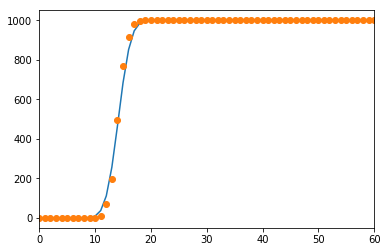

In [151]:
a = sCurve[255] - sCurve[0]
plt.plot(a * .5 * (1 + erf((x-mu)/sigma)))
plt.plot(x,sCurve,'o')
plt.xlim(0,60)
plt.show()

In [93]:
def errorf(x, *p):
    a, mu, sigma = p
    return 0.5*a*(1.0+erf((x-mu)/sigma))

def errorfc(x, *p):
    a, mu, sigma = p
    return a*0.5*erfc((x-mu)/sigma)

def extract_scurve(s_curve,s_type="CAL",n_pulse=1000,nominal_DAC=-1,start=0,stop=256):
    if nominal_DAC == -1:
        if s_type=="THR":
            nominal_DAC = 85
        elif s_type=="CAL":
            nominal_DAC = 15
    mean = -1
    rms  = -1
    scurve = np.array(s_curve)
    #scurve = scurve[0][:257]
    fitsuccess = True;
    #print (s_type,n_pulse,nominal_DAC,start,stop)
    try:
        if s_type == "THR":
            start_DAC = np.argmax(scurve)+10
            while start_DAC <  (stop-start):
                if math.fabs(scurve[start_DAC] - n_pulse) < math.sqrt(n_pulse):
                    break
                start_DAC += 1
            if start_DAC >= stop-start-1:
                start_DAC = min(np.argmax(scurve)+10,stop-start-5)    
                #print("Fit Range (",start_DAC," to ", (stop-start), ") with initial parameters ", [n_pulse, nominal_DAC, 2],"for pixel",pixel)
                #print("A",range(start_DAC, (stop-start)))
                #print("B",scurve)
            par, cov = curve_fit(errorfc, range(start_DAC, (stop-start)), scurve[start_DAC + 1 :(stop-start) + 1], p0= [n_pulse, (start_DAC+(stop-start))/2, 2])
            #print("Paramters from fit ",par)
            #print("Covariance ", cov)
            mean = par[1]
            rms  = par[2]
        elif s_type == "CAL":
            start_DAC = 0
            #print("Fit Range (",start_DAC," to ", (stop-start), ") with initial parameters ", [n_pulse, nominal_DAC, 2])
            par, cov = curve_fit(errorf,  range(start_DAC, (stop-start)), scurve[start_DAC + 1 :(stop-start) + 1], p0= [n_pulse, nominal_DAC, 2])
            #print("Paramters from fit ",par)
            #print("Covariance ", cov)
            mean = par[1]
            rms  = par[2]
    except RuntimeError or TypeError:
        fitsuccess = False
        #print("Fit fails for input data")
        #print(s_curve)

    return mean,rms,fitsuccess


In [86]:
extract_scurve(s)

(13.04024440457049, 1.8620382398043471, True)

In [110]:
def extract_meanrms_fromSCurves(scurves,s_type="CAL",n_pulse=1000,nominal_DAC=-1,start=0,stop=256):
    means = []
    rmss = []
    #print("TTT",len(scurves),type(scurves))
    #print("TTTT",scurves)
    for s_curve in scurves:
        #print("SSSS",s_curve)
        meanf,rmsf,fitf = extract_scurve(s_curve=s_curve,s_type=s_type,n_pulse=n_pulse,nominal_DAC=nominal_DAC,start=start,stop=stop)
        meand,rmsd,fitd = extract_scurve_differentiate(s_curve=s_curve,s_type=s_type,n_pulse=n_pulse,nominal_DAC=nominal_DAC,start=start,stop=stop)
        #print("1")
        if s_type == "THR":
            meansfT.append(meanf)
            meansdT.append(meand)
        elif s_type == "CAL":
            meansfC.append(meanf)
            meansdC.append(meand)
        mean,rms,fit = extract_scurve(s_curve=s_curve,s_type=s_type,n_pulse=n_pulse,nominal_DAC=nominal_DAC,start=start,stop=stop)
        means.append(mean)
        rmss.append(rms)
        print(meand)
    #return means,rmss
    return meansdC

In [111]:
meansfC = []
meansdC = []
extract_meanrms_fromSCurves(s)

len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
len(scurve) 257, len(DACvals) 256
-1
l

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
